In [1]:
import numpy as np
import numpy.ma as ma

from astropy.table import QTable, Table

import sys
sys.path.insert(1,"/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/")
#sys.path.insert(1, '/home/kelly/Documents/RotationCurves/spirals/')
from DRP_rotation_curve import extract_data
from DRP_vel_map_functions import model_vel_map, find_center, find_phi, deproject_spaxel
from DRP_vel_map_plottingFunctions import plot_rot_curve

#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr16/manga/spectro/'
#MANGA_FOLDER = '/home/kelly/Documents/Data/SDSS/dr16/manga/spectro/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'

# Sample galaxy properties

In [53]:
#gal_ID = '7443-12705'
gal_ID = '9869-1902'

manga_plate, manga_IFU = gal_ID.split('-')

In [54]:
Ha_vel, Ha_vel_ivar, Ha_vel_mask, r_band, r_band_ivar, Ha_flux = extract_data(VEL_MAP_FOLDER, gal_ID)

mr_band = ma.array(r_band, mask=Ha_vel_mask)
mHa_vel = ma.array(Ha_vel, mask=Ha_vel_mask)
mHa_vel_ivar = ma.array(Ha_vel_ivar, mask=Ha_vel_mask)

SN = Ha_flux*np.sqrt(Ha_vel_ivar)
m10Ha_vel = ma.array(Ha_vel, mask=np.logical_or(Ha_vel_mask > 0, np.abs(SN) < 1))#0.05*np.max(np.abs(SN))))
print(0.05*np.max(np.abs(SN)))

3.6847583770751955


In [55]:
#oneD_fit_file = '../spirals/DRPall-master_file_30.txt'
oneD_fit_file = '../spirals/Pipe3D-master_file_vflag_BB_minimize_chi10_smooth2p27_mapFit_N2O2_HIdr2_noWords_v2.txt'

#oneD_fit_parameters = QTable.read(oneD_fit_file, format='ascii.ecsv')
oneD_fit_parameters = Table.read(oneD_fit_file, format='ascii.commented_header')

gal_oneD_fit_parameters_boolean = np.logical_and(oneD_fit_parameters['MaNGA_plate'] == int(manga_plate), 
                                                 oneD_fit_parameters['MaNGA_IFU'] == int(manga_IFU))

gal_oneD_fit_parameters_row = oneD_fit_parameters[gal_oneD_fit_parameters_boolean]

In [56]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

MANGA_FIBER_DIAMETER = 2*(1/60)*(1/60)*(np.pi/180) # angular fiber diameter (2") in radians
MANGA_SPAXEL_SIZE = 0.5*(1/60)*(1/60)*(np.pi/180)  # spaxel size (0.5") in radians


#dist_to_galaxy_Mpc = c*gal_oneD_fit_parameters_row['redshift'][0]/H_0
dist_to_galaxy_Mpc = c*gal_oneD_fit_parameters_row['NSA_redshift'][0]/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

pix_scale_factor = dist_to_galaxy_kpc*np.tan(MANGA_SPAXEL_SIZE)

In [57]:
################################################################################
# Inclination angle (from photometry)
#-------------------------------------------------------------------------------
print(gal_oneD_fit_parameters_row['NSA_ba'][0])
i_angle = np.arccos(gal_oneD_fit_parameters_row['NSA_ba'][0])
#i_angle = np.arccos(0.568)

i_angle_map_fit = np.arccos(gal_oneD_fit_parameters_row['ba_map'][0])
################################################################################


################################################################################
# Photometric center of galaxy
#-------------------------------------------------------------------------------
center = np.unravel_index(ma.argmax(mr_band), mr_band.shape)

x0 = gal_oneD_fit_parameters_row['x0_map'][0]
y0 = gal_oneD_fit_parameters_row['y0_map'][0]
################################################################################


################################################################################
# Systemic velocity (velocity at galaxy's center)
#-------------------------------------------------------------------------------
v_sys = mHa_vel[center]

v_sys_map_fit = gal_oneD_fit_parameters_row['Vsys_map'][0]
################################################################################


################################################################################
# Rotation angle (from photometry)
#-------------------------------------------------------------------------------
phi = gal_oneD_fit_parameters_row['NSA_phi'][0]#.value
#phi = 156.758

phi_guess = find_phi(center, phi, mHa_vel)

phi_map_fit = gal_oneD_fit_parameters_row['phi_map'][0]

print(phi, phi_guess*180/np.pi, phi_map_fit)
################################################################################


################################################################################
# Curve used (for 1D fit)
#-------------------------------------------------------------------------------
'''
curve = gal_oneD_fit_parameters_row['curve_used'][0]

if curve in ['none', 'non']:
    curve = 'avg'
'''
best_rot_curve = gal_oneD_fit_parameters_row['curve_used'][0]

if best_rot_curve == -1:
    curve = 'neg'
elif best_rot_curve == 1:
    curve = 'pos'
else:
    curve = 'avg'

print(best_rot_curve, curve)
################################################################################


################################################################################
# Maximum velocity
#-------------------------------------------------------------------------------
v_max = gal_oneD_fit_parameters_row[curve + '_v_max'][0]#.value

v_max_index = np.unravel_index(ma.argmax(np.abs(mHa_vel)), mHa_vel.shape)
v_max_guess = np.abs(mHa_vel[v_max_index]/np.sin(i_angle))

v_max_map_fit = gal_oneD_fit_parameters_row['Vmax_map'][0]
################################################################################


################################################################################
# Turn radius
#-------------------------------------------------------------------------------
r_turn = gal_oneD_fit_parameters_row[curve + '_r_turn'][0]#.value

r_turn_guess_spaxels,_ = deproject_spaxel(v_max_index, 
                                          center, 
                                          phi_guess, 
                                          i_angle)

r_turn_guess = 0.5*r_turn_guess_spaxels*pix_scale_factor

if r_turn_guess < 0.01:
    r_turn_guess = 1.1*0.01
    
r_turn_map_fit = gal_oneD_fit_parameters_row['Rturn_map'][0]
################################################################################


################################################################################
# alpha
#-------------------------------------------------------------------------------
alpha = gal_oneD_fit_parameters_row[curve + '_alpha'][0]

alpha_guess = 2

alpha_map_fit = gal_oneD_fit_parameters_row['alpha_map'][0]
################################################################################


params = [v_sys, i_angle, center[0], center[1], phi_guess, v_max, r_turn, alpha]
initial_guess_params = [v_sys, 
                        i_angle, 
                        center[0], 
                        center[1], 
                        phi_guess, 
                        v_max_guess, 
                        r_turn_guess, 
                        alpha_guess]
map_fit_params = [v_sys_map_fit,
                  i_angle_map_fit,
                  x0,
                  y0,
                  phi_map_fit,
                  v_max_map_fit,
                  r_turn_map_fit,
                  alpha_map_fit]

print('1D parameters:', params)
print('Initial guess:', initial_guess_params)
print('Fitted map:', map_fit_params)

best_fit_values = {'v_sys':v_sys,
                   'ba':gal_oneD_fit_parameters_row['NSA_ba'][0],
                   'x0':center[0],
                   'y0':center[1],
                   'phi':phi_guess,
                   'r_turn':r_turn,
                   'v_max':v_max,
                   'alpha':alpha}
best_fit_values_degrees = {'v_sys':v_sys,
                           'ba':gal_oneD_fit_parameters_row['NSA_ba'][0],
                           'x0':center[0],
                           'y0':center[1],
                           'phi':phi_guess*180./np.pi,
                           'r_turn':r_turn,
                           'v_max':v_max,
                           'alpha':alpha}
map_fit_params_dict = {'v_sys':map_fit_params[0], 
                       'ba': gal_oneD_fit_parameters_row['ba_map'][0],
                       'x0': map_fit_params[2], 
                       'y0': map_fit_params[3], 
                       'phi': map_fit_params[4]*180./np.pi,
                       'v_max': map_fit_params[5], 
                       'r_turn': map_fit_params[6], 
                       'alpha': map_fit_params[7]}

0.44487494230270386
90.83633422851562 270.8363342285156 266.23840352367023
0 avg
1D parameters: [-3.499509, 1.1097617076020139, 16, 16, 4.726985766319414, 107.19826009416416, 3.1043781838962765, 44.603703099251895]
Initial guess: [-3.499509, 1.1097617076020139, 16, 16, 4.726985766319414, 497.64697162828384, 1.2912906243079951, 2]
Fitted map: [-23.657643588607627, 0.9432297044199941, 17.18156446520732, 15.239547180205372, 266.23840352367023, 621.1828099941497, 2.75144312550027, 6.516185894166497]


In [58]:
map_shape = mHa_vel.shape

# Test `model_vel_map`

In [59]:
model_map_BB = model_vel_map(initial_guess_params, #map_fit_params,
                             map_shape, 
                             pix_scale_factor, 
                             'BB')

model_map_tanh = model_vel_map(initial_guess_params[:-1], #map_fit_params[:-1], 
                               map_shape, 
                               pix_scale_factor, 
                               'tanh')

<IPython.core.display.Javascript object>


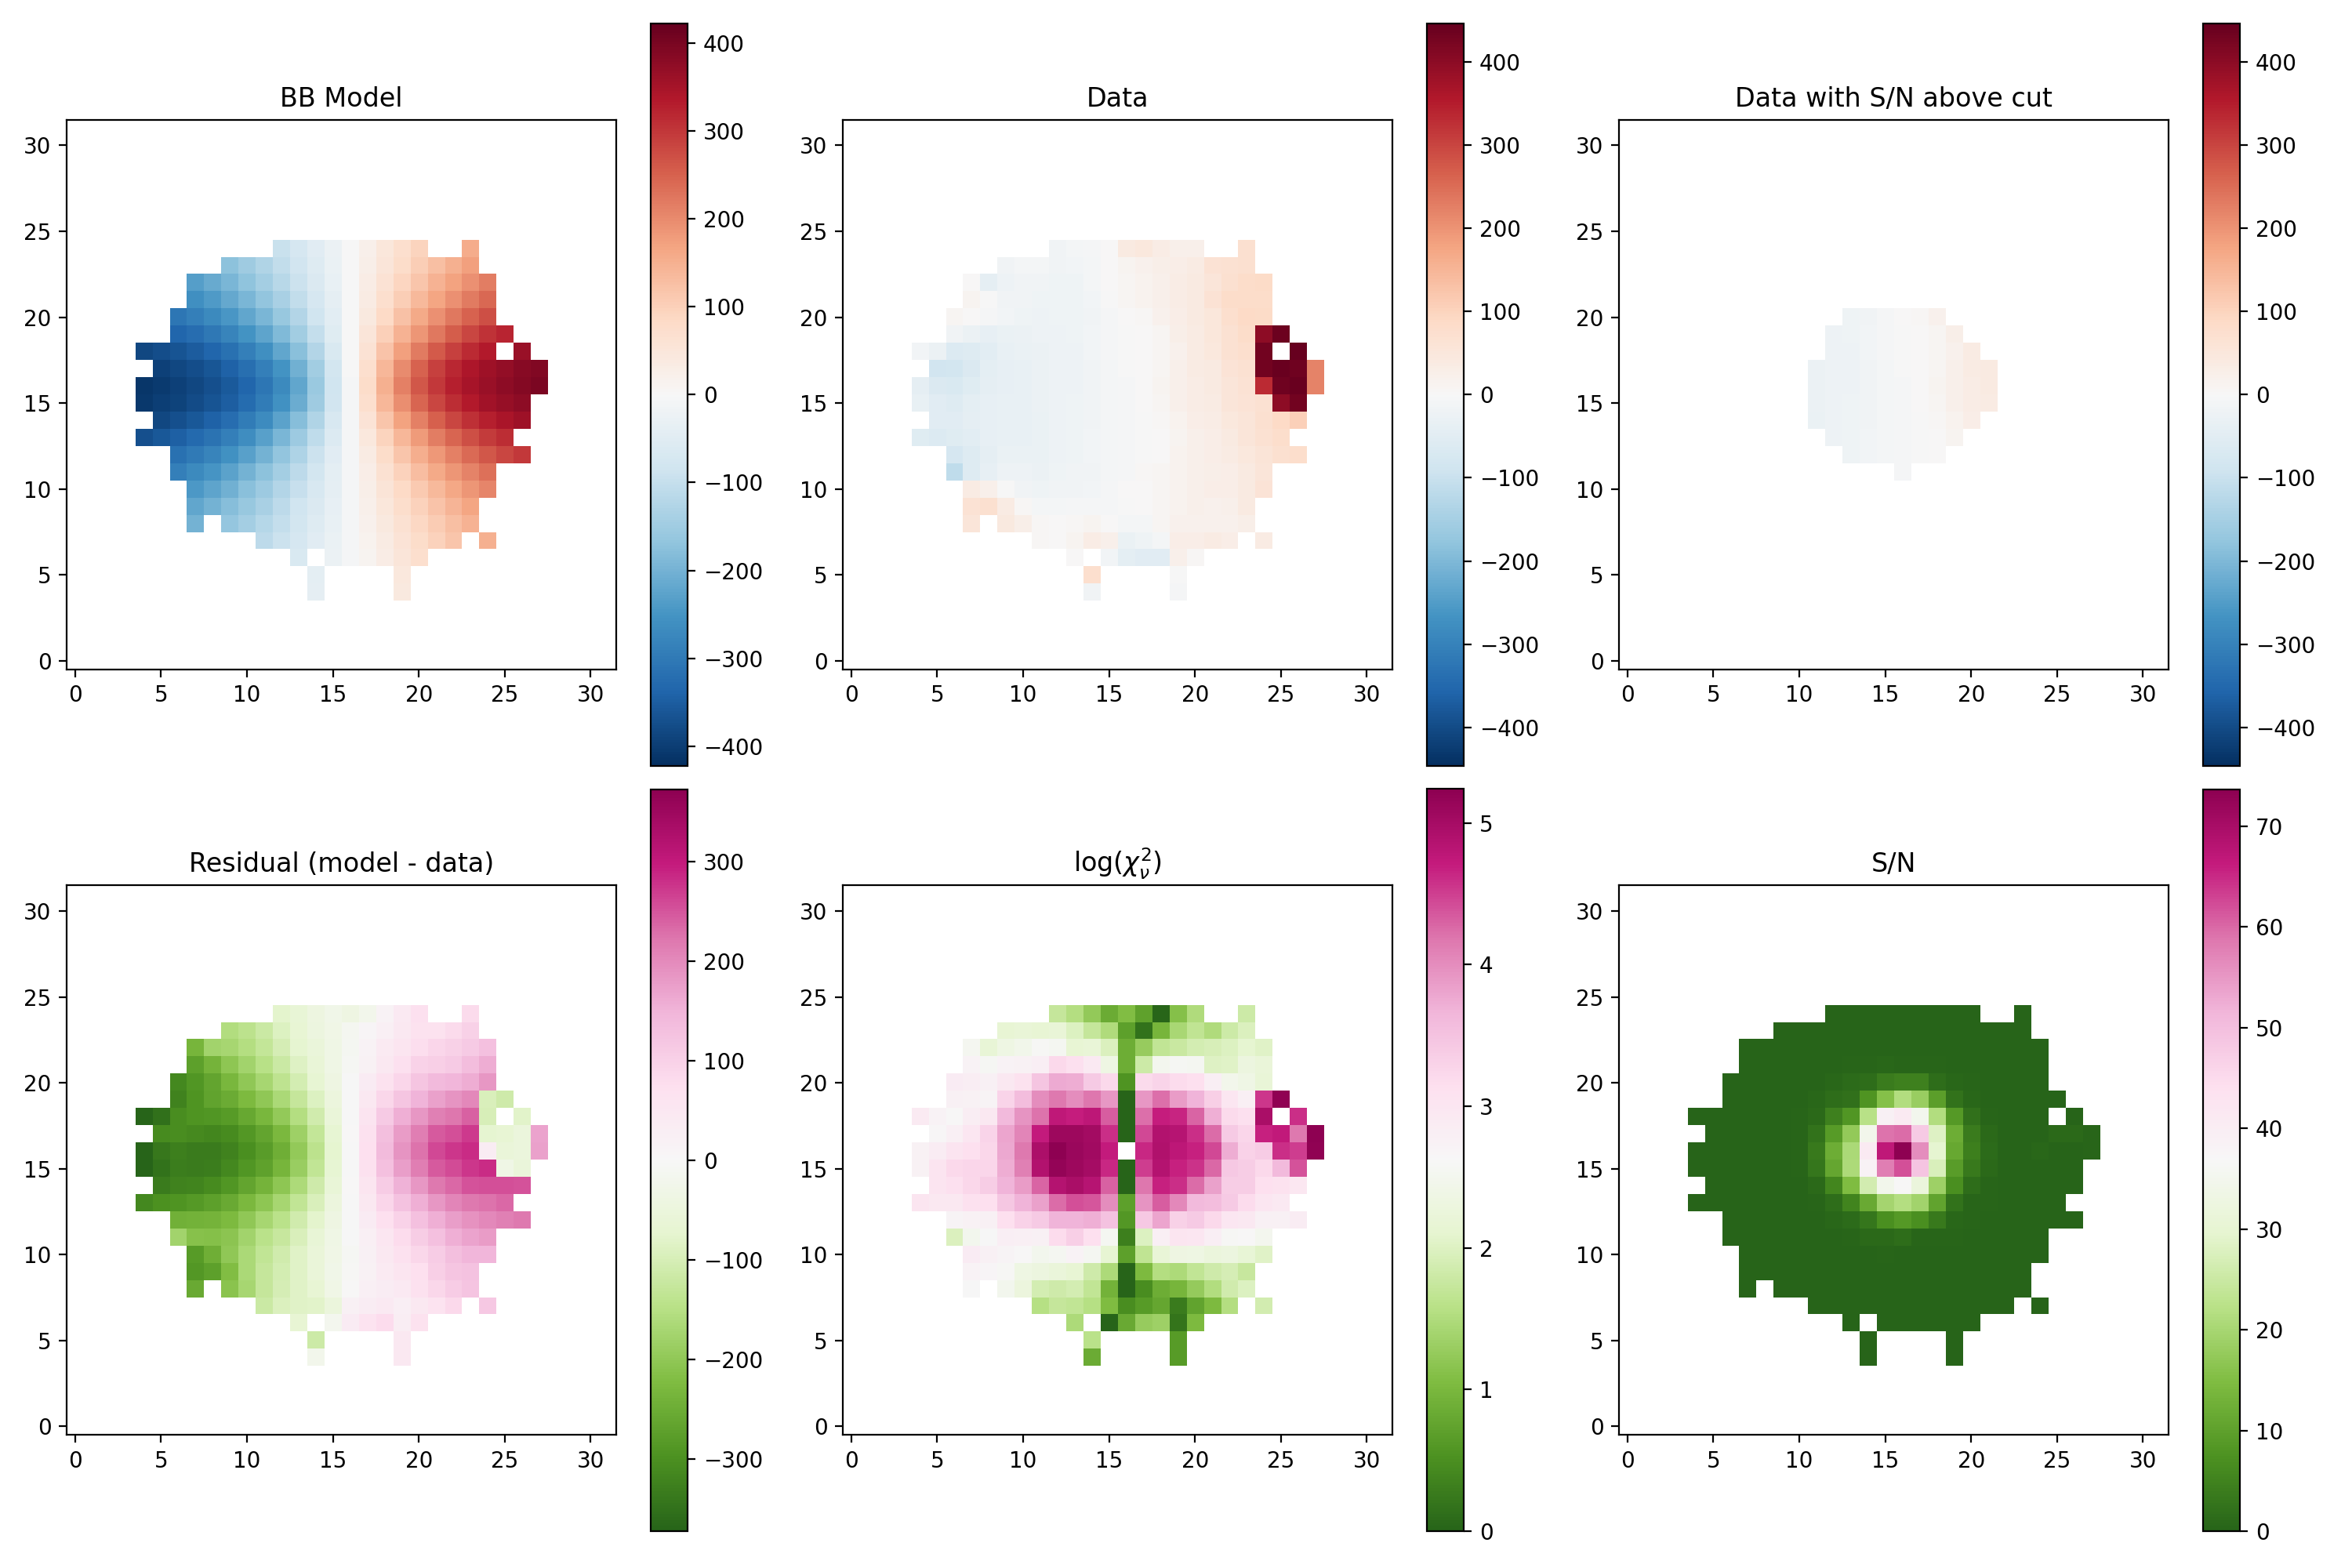

<ipython-input-60-63d08f7ac65b>:39: RuntimeWarning: divide by zero encountered in log10
  chi2_BB = np.max(np.log10(Ha_vel_ivar*(model_map_BB - mHa_vel)**2))
<ipython-input-60-63d08f7ac65b>:40: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(Ha_vel_ivar*(model_map_BB - mHa_vel)**2),


In [60]:
plt.figure(figsize=(15,10))

plt.subplot(231)
v_max_model_BB = np.max(np.abs(model_map_BB - v_sys))
#plt.imshow(ma.array(model_map_BB - v_sys, mask=mHa_vel.mask), 
plt.imshow(ma.array(model_map_BB, mask=mHa_vel.mask), 
           vmin=-v_max_model_BB, vmax=v_max_model_BB, 
           origin='lower', 
           cmap='RdBu_r')
plt.colorbar()
plt.title('BB Model')

plt.subplot(232)
extreme2 = np.max(np.abs(mHa_vel))
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-extreme2, vmax=extreme2)
plt.colorbar()
plt.title('Data')

plt.subplot(233)
plt.imshow(m10Ha_vel, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-extreme2, 
           vmax=extreme2)
plt.colorbar()
plt.title('Data with S/N above cut')

plt.subplot(234)
residual_BB = np.max(np.abs(model_map_BB - mHa_vel))
plt.imshow(model_map_BB - mHa_vel, 
           origin='lower', 
           cmap='PiYG_r', 
           vmin=-residual_BB, 
           vmax=residual_BB)
plt.colorbar()
plt.title('Residual (model - data)')

plt.subplot(235)
chi2_BB = np.max(np.log10(Ha_vel_ivar*(model_map_BB - mHa_vel)**2))
plt.imshow(np.log10(Ha_vel_ivar*(model_map_BB - mHa_vel)**2), 
           cmap='PiYG_r', 
           origin='lower', 
           vmin=0, 
           vmax=chi2_BB)
plt.colorbar()
plt.title(r'log($\chi^2_{\nu}$)')

plt.subplot(236)
plt.imshow(ma.array(np.abs(SN), mask=Ha_vel_mask), 
           cmap='PiYG_r', 
           origin='lower', 
           vmin=0, 
           vmax=np.max(np.abs(SN)))
plt.colorbar()
plt.title('S/N')

'''
plt.subplot(234)
#plt.imshow(model_map_tanh - v_sys, origin='lower', cmap='RdBu_r')
plt.imshow(model_map_tanh, origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.title('tanh Model')

plt.subplot(235)
residual_tanh = np.max(np.abs(model_map_tanh - mHa_vel))
plt.imshow(model_map_tanh - mHa_vel, origin='lower', cmap='PiYG_r', vmin=-residual_tanh, vmax=residual_tanh)
plt.colorbar()
plt.title('Residual (model - data)')

plt.subplot(236)
plt.imshow(model_map_BB - model_map_tanh, origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.title('Model difference (BB - tanh)')
'''
plt.tight_layout();

# Test `plot_rot_curve`

<IPython.core.display.Javascript object>


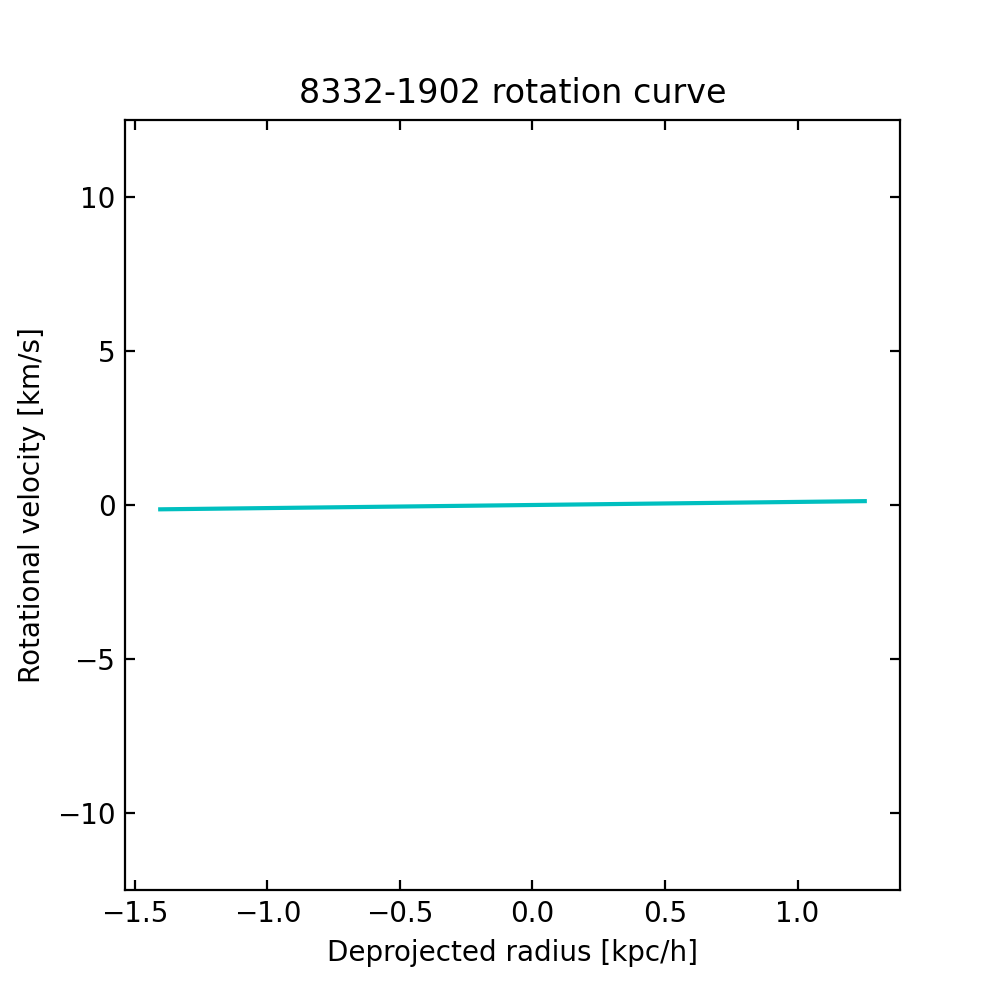

In [38]:
#plot_rot_curve(mHa_vel, mHa_vel_ivar, best_fit_values_degrees, pix_scale_factor, gal_ID, 'BB');
plot_rot_curve(mHa_vel, mHa_vel_ivar, map_fit_params_dict, pix_scale_factor, gal_ID, 'BB');

<IPython.core.display.Javascript object>


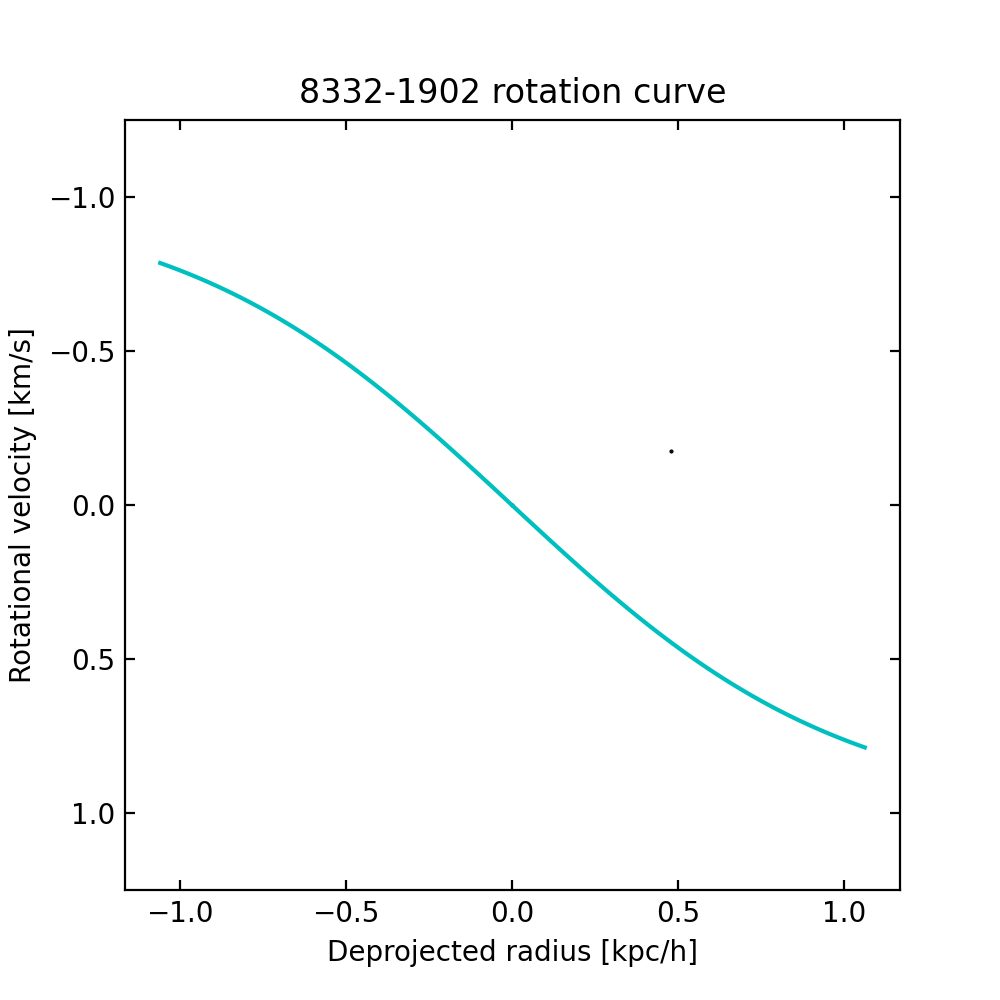

In [12]:
plot_rot_curve(mHa_vel, mHa_vel_ivar, best_fit_values_degrees, pix_scale_factor, gal_ID, 'tanh')

In [40]:
model_map_BB_masked = ma.array(model_map_BB, mask=np.zeros(map_shape))

plot_rot_curve(model_map_BB_masked, 
               mHa_vel_ivar, 
               map_fit_params_dict, #best_fit_values_degrees, 
               pix_scale_factor, 
               gal_ID, 
               'BB');

<IPython.core.display.Javascript object>

# Test `find_center`

In [9]:
maybe_center = find_center(mHa_vel)

In [10]:
maybe_center

(43, 46)

<IPython.core.display.Javascript object>


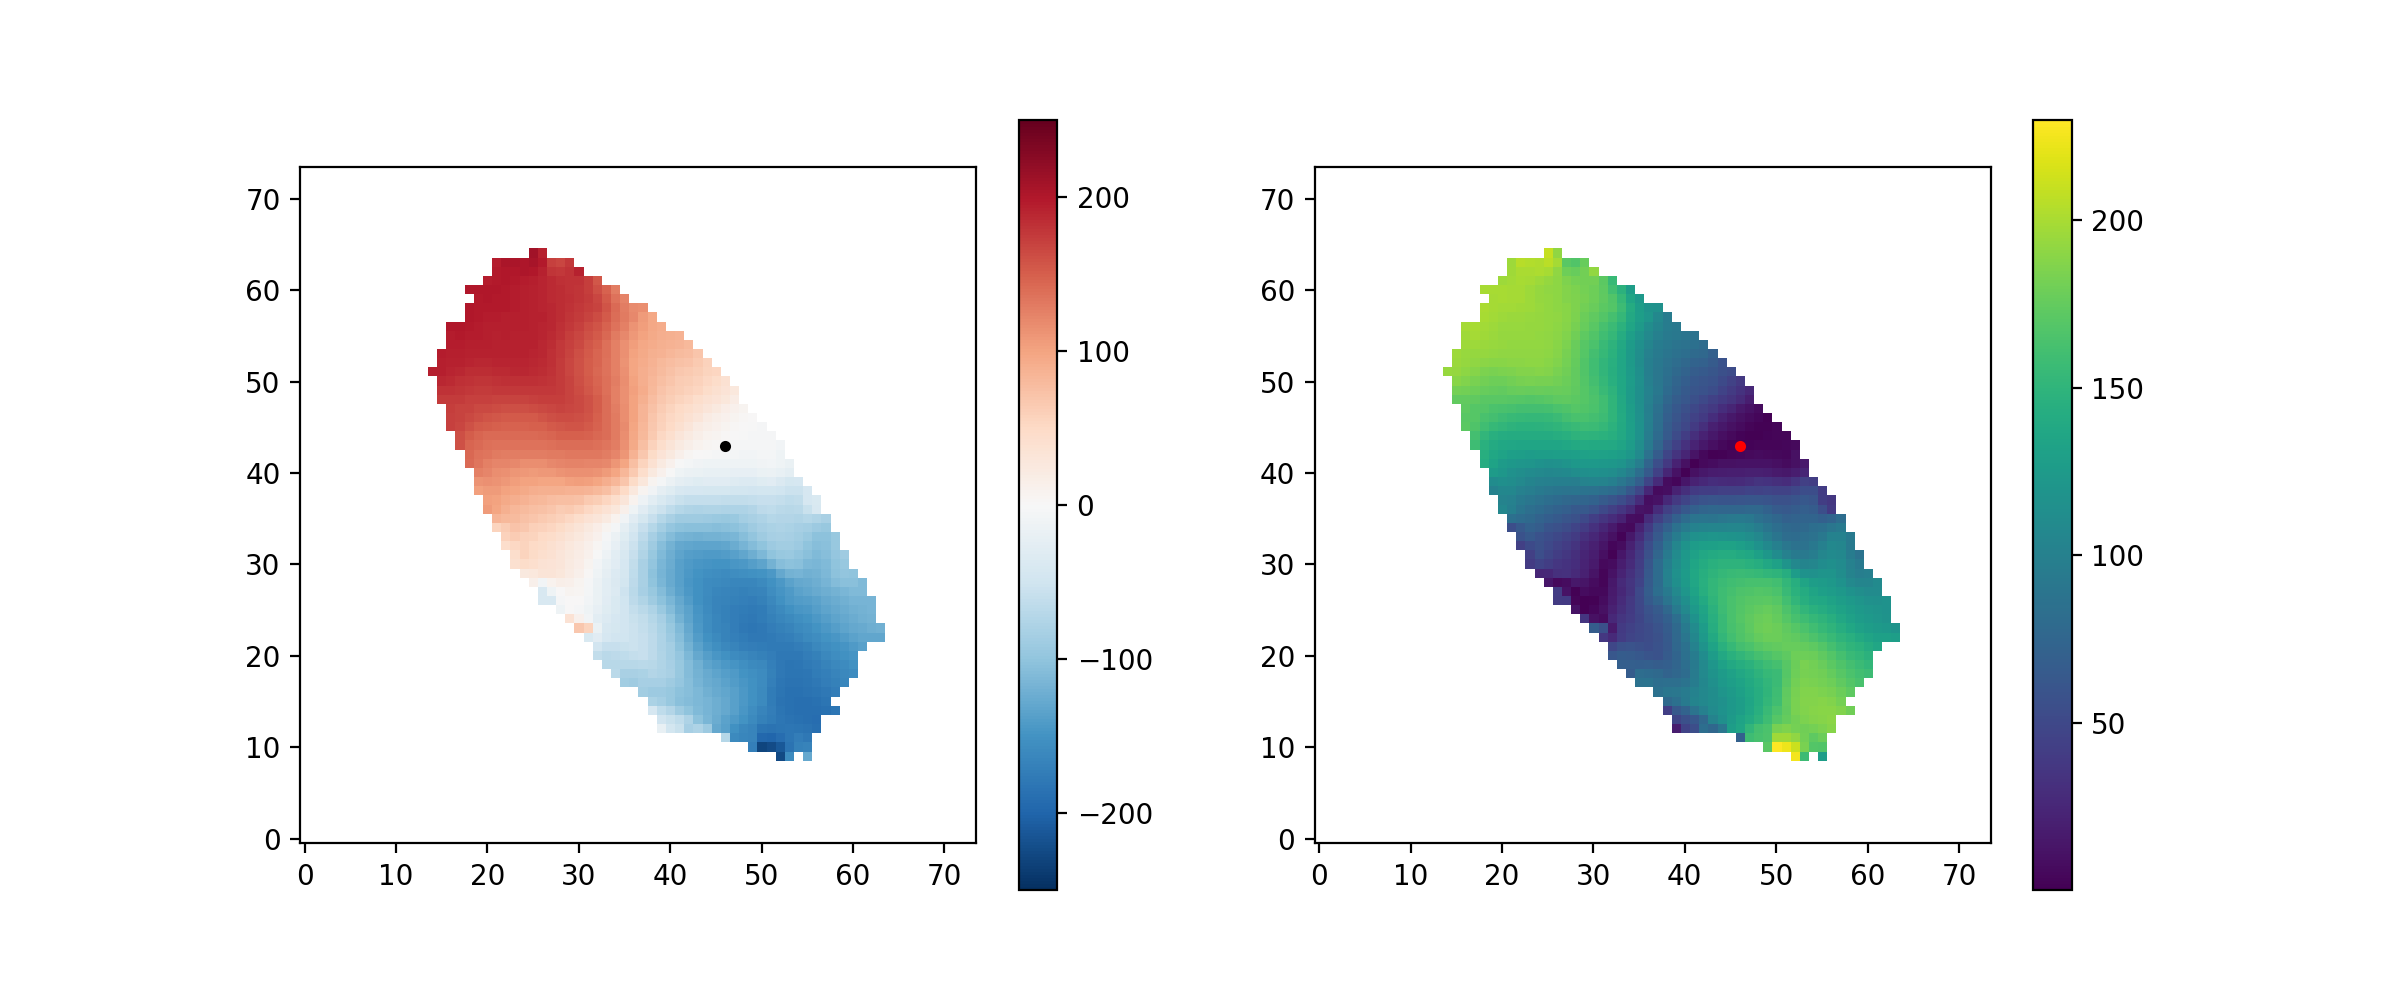

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-250, vmax=250)
plt.plot(maybe_center[1], maybe_center[0], 'k.')
plt.colorbar()

plt.subplot(122)
plt.imshow(np.abs(mHa_vel), origin='lower')
plt.plot(maybe_center[1], maybe_center[0], 'r.')
plt.colorbar();

In [12]:
x = np.arange(map_shape[0])
X, Y = np.meshgrid(x,x)

<IPython.core.display.Javascript object>


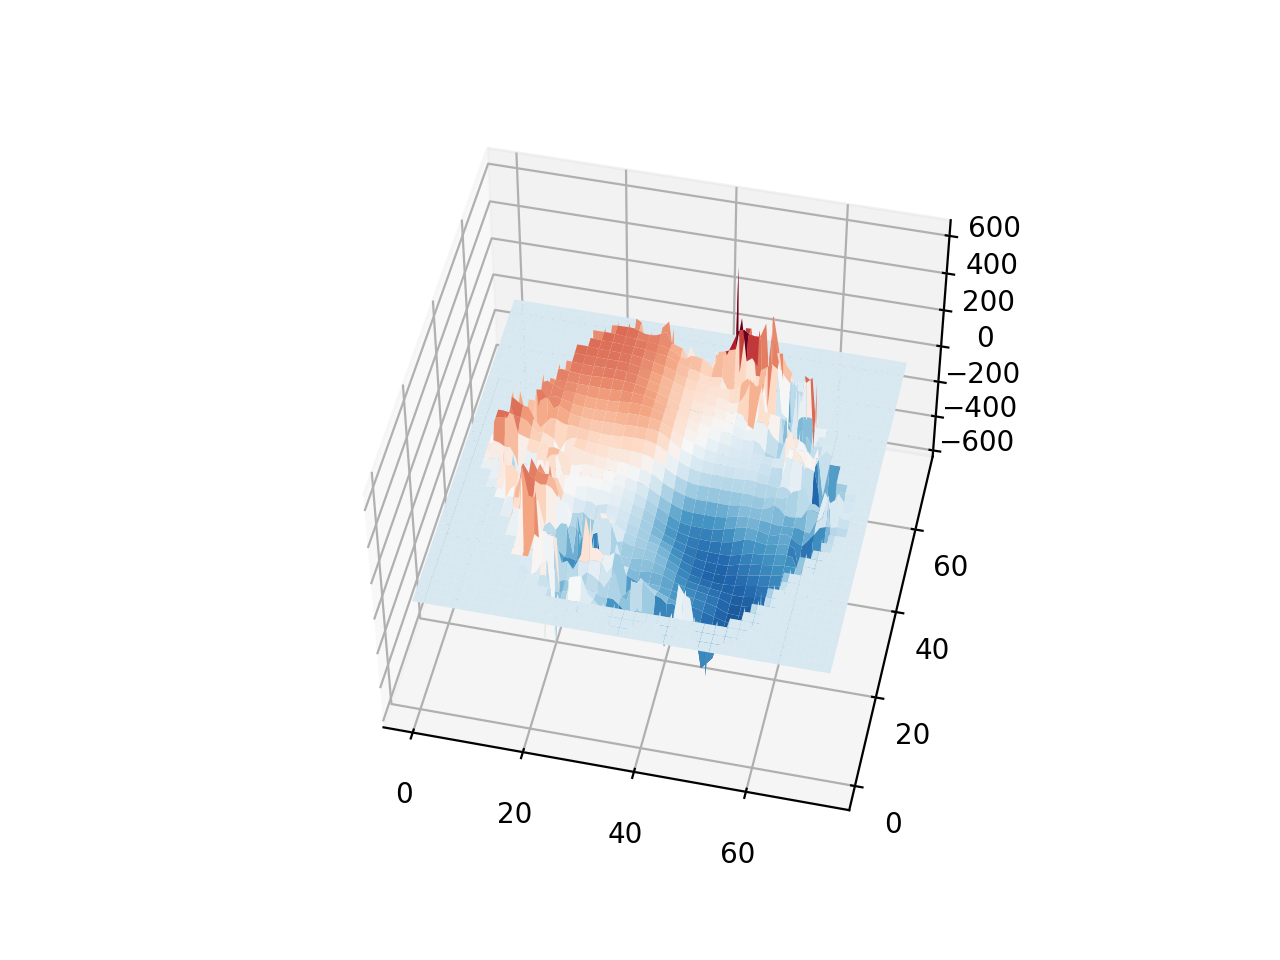

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, mHa_vel, cmap='RdBu_r');
#plt.colorbar();

In [28]:
i_angle

1.0683978716829448